# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

Primero se hace la importación de las librearías que se usarán durante el proyecto

In [1]:
# importe de librerías
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
display(df.sample(3))

,datetime,num_orders
22748,2018-08-05 23:20:00,22
22435,2018-08-03 19:10:00,19
23700,2018-08-12 14:00:00,24


***Conclusión***

El dataset tiene sólo dos columnas sin valores ausentes. Para convertirlo en una serie temporal con la que se pueda trabajar, debemos convertir la columna `'datetime'` a un tipo de datos `datetime`. 

Después convertimos esa columna de fechas en el índice y lo ordenamos

In [4]:
# Conversión del tipo de datos
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Convertimos la columna datetime como el índice
df = df.set_index('datetime')

Aunque parece que los índices están ordenados, es mejor asegurarlo usando el método `sort_index`

In [6]:
# ordenamos el índice
df.sort_index(inplace=True)

### Remuestreo

Se ha solicitado que los datos sean remuestrados de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora. Para esto se ocupará el método `max()`

In [7]:
# Remuestreo
df = df.resample('1H').max()

In [8]:
# Comprobamos TODOS los cambios realizados
df.info()
print()
print(df.describe())
print()
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB

        num_orders
count  4416.000000
mean     21.393569
std      10.498341
min       0.000000
25%      14.000000
50%      20.000000
75%      27.000000
max     119.000000



,num_orders
datetime,
2018-08-02 23:00:00,33
2018-06-09 11:00:00,22
2018-06-14 11:00:00,18
2018-05-18 01:00:00,25
2018-08-30 23:00:00,48


***Conclusión***

Todos los cambios se realizaron con éxito y podemos observar que la cantidad de renglones disminuyó de 26496 4416. Se han preparado los datos y podemos realizar un análisis.

## Análisis

Se va a realizar una gráfica para graficar el promedio de los números de ordenes que hay en cada hora, independientemente de la fecha, con el fin de ver en que hora hay más ordenes de taxis a los aeropuertos.

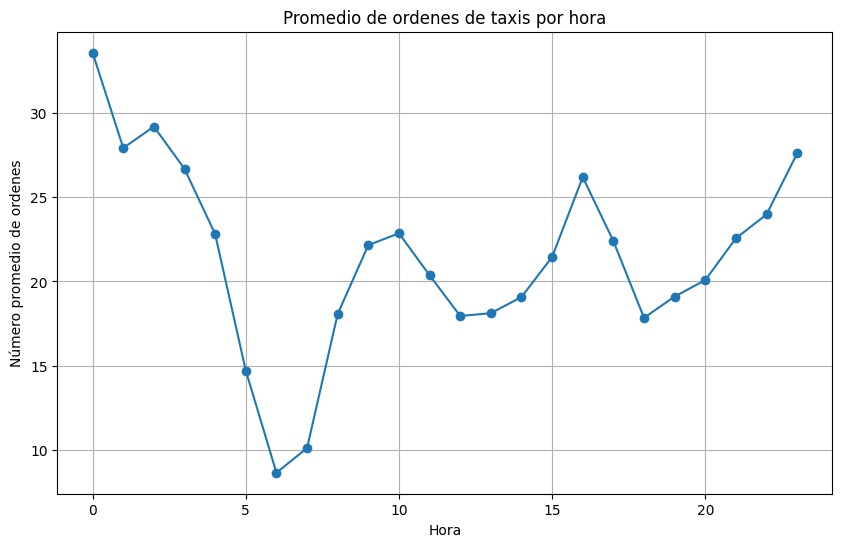

In [9]:
# Graficar por hora el promedio de ordenenes de taxis
plt.figure(figsize=(10, 6))
df.groupby(df.index.hour)['num_orders'].mean().plot(marker='o')
plt.title('Promedio de ordenes de taxis por hora')
plt.xlabel('Hora')
plt.ylabel('Número promedio de ordenes')
plt.grid(True)
plt.show()

Podemos observar que la hora en la que más taxis son solicitados es a las 00:00 horas y tan sólo 6 horas despues desceiende hasta su pico más chico.

Pero, ¿en qué mes son más solicitados los taxis?

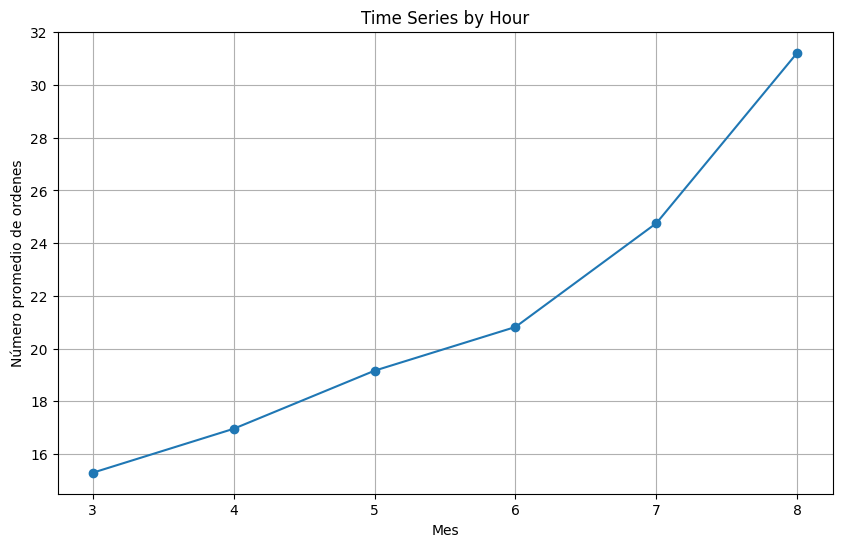

In [10]:
# Graficar por mes el promedio de ordenenes de taxis
plt.figure(figsize=(10, 6))
df.groupby(df.index.month)['num_orders'].mean().plot(marker='o')
plt.title('Time Series by Hour')
plt.xlabel('Mes')
plt.ylabel('Número promedio de ordenes')
plt.grid(True)
plt.show()

Podemos observar que los números de pedidos van creciendo conforme termina el año. Marzo tiene menos de 16 ordenes de taxis, en promedio. Mientras que agosto supera las 30 ordenes de taxis, en promedio.

Se puede concluir que en el año 2018 durante el verano, el número de personas que viajan es mayor que en primavera.

### Tendencias y estacionalidad

Se va a analizar la tendencia y la estacionalidad del dataset para buscar pequeños cambios ligeros o si hay patrones que se repiten.

In [11]:
# separación del dataset
decomposed = seasonal_decompose(df)

**Tendencia**

Text(0.5, 1.0, 'Tendencia')

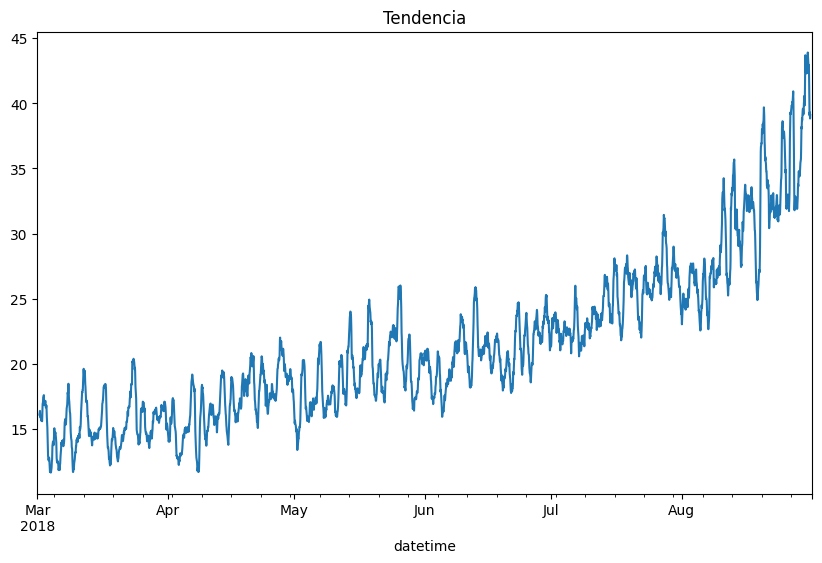

In [12]:
# Gráfica para ver la tendencia
plt.figure(figsize=(10,6))
plt.subplot()
decomposed.trend.plot()
plt.title('Tendencia')

***Conclusión***

Como ya se había mencionado, se observa que la tendencia es que el número de ordenes de taxis vaya aumentando conforme pasan los meses.

**Estacionalidad**

Vamos a ver si los mismos patrones se repiten en los meses de marzo y agosto. Se toman estos meses debido a que son los meses con menor y mayor número de ordenes de taxi.

Text(0.5, 1.0, 'Estacionalidad del mes de Marzo')

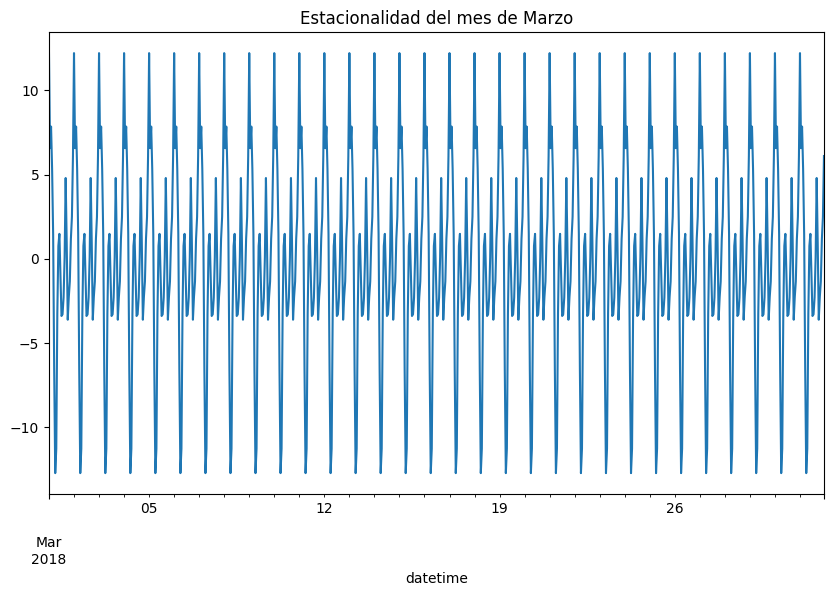

In [13]:
# Estacionalidad del mes de Marzo
plt.figure(figsize=(10,6))
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title('Estacionalidad del mes de Marzo')

Con esto podemos decir que día con día el patron es que unas horas hay mucha demanda de ordenes de taxi y otras no. En la gráfica "Promedio de ordenes de taxis por hora" podemos ver que la tendencia es que en la noche hay más demanda que en la mañana.

Text(0.5, 1.0, 'Estacionalidad del mes de Agosto')

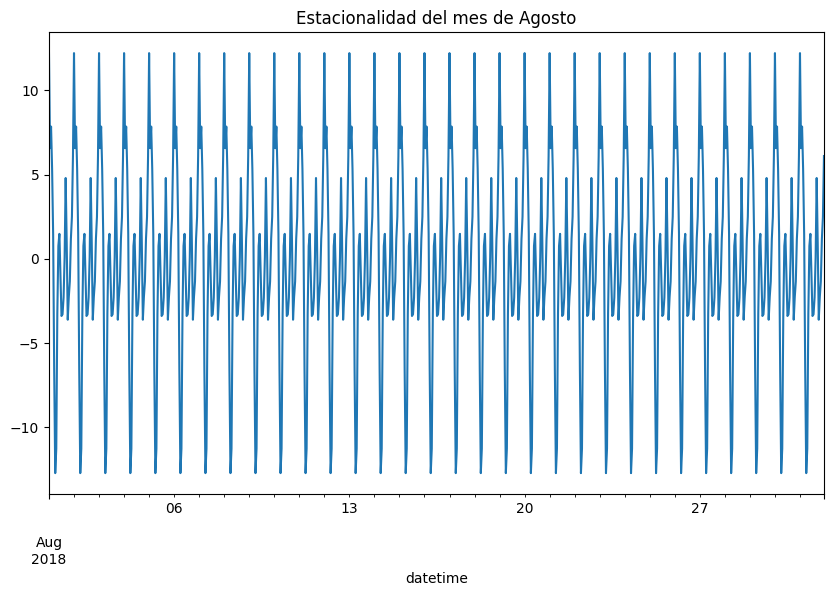

In [14]:
# Estacionalidad del mes de Agosto
plt.figure(figsize=(10,6))
decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.title('Estacionalidad del mes de Agosto')

La estacionalidad es igual durante el mes de marzo y el mes de agosto, a pesar de que hay más odrdenes de taxis durante el mes de agosto.

## Formación

### Creación de características

Para poder entrenar modelos de predicción es necesario crear más características, para lo cual se desarrollará una función que realice esta tarea. Dicha función creará características de calendario, características de desfase y caracaterísticas de media móvil.

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    # Características de calendario
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    # Características de desfase
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    # Media móvil
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
# Llamada de la función con un max_lag de 4 y un rolling_mean_size de 4
make_features(df, 4, 4)

# Comprobamos que se agregaron las columnas
display(df.head(5))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,32,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,25,2018,3,1,3,32.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,22,2018,3,1,3,25.0,32.0,NaN,NaN,NaN
2018-03-01 03:00:00,20,2018,3,1,3,22.0,25.0,32.0,NaN,NaN
2018-03-01 04:00:00,17,2018,3,1,3,20.0,22.0,25.0,32.0,24.75


### Divisón del dataset

El dataset será dividido en entrenamiento y prueba y estos a su vez en características y objetivo.

Se ha solicitado que la prueba sólo tengo el 10% de los datos.

In [17]:
# División en entrenamiento y prueba
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [18]:
# Se borran los valores NaN
train=train.dropna()

In [19]:
# División de características y objetivo
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

## Entrenamiento de modelos

Se van a entrenar 3 modelos modificando los parámetros, se va a escoger el modelo con un RMSE menor a 48.

Las predicciones se realizarán con el mismo conjunto de entrenamiento, posteriormente se realizará la predicción con el conjunto de prueba pero solamente con el mejor modelo.

###  Bosque aleatorio de regresión

Para este modelo se van a utilizar un ciclo for para modificar los hiperparámetros `n_estimators` y `depth` y ver cuál da como resultado un mejor RMSE.

In [20]:
# Se establece un contador para saber cuál es el mejor valor de  n_estimators y max_depth
best_rmse = 10000
best_est = 0
best_depth = 0

In [21]:
# Modelo en un ciclo for
for est in range(10, 11):
    for depth in range(1,11):
        model_tree = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_tree.fit(features_train, target_train)
        predict_tree = model_tree.predict(features_train)
        rmse = mean_squared_error(target_train, predict_tree, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_est = est
            best_depth = depth

print(f'El RMSE del mejor modelo, con depth = {best_depth} y n_estimators = {best_est}, es: {best_rmse}')

El RMSE del mejor modelo, con depth = 10 y n_estimators = 10, es: 5.415825899587262


### CatBoostRegressor 

In [22]:
# Entrenamiento del modelo
model_cat = CatBoostRegressor(loss_function='RMSE', learning_rate=0.5, depth=4, n_estimators=500, random_state=12345)
model_cat.fit(features_train, target_train, verbose=100)

0:	learn: 8.0679815	total: 46.9ms	remaining: 23.4s
100:	learn: 5.9829009	total: 137ms	remaining: 540ms
200:	learn: 5.4120012	total: 225ms	remaining: 335ms
300:	learn: 5.0344579	total: 313ms	remaining: 207ms
400:	learn: 4.6857314	total: 413ms	remaining: 102ms
499:	learn: 4.4453117	total: 500ms	remaining: 0us


In [23]:
# Predicción
predict_cat = model_cat.predict(features_train)

In [24]:
# Calculo del RMSE
rmse_cat = mean_squared_error(target_train, predict_cat, squared=False)
print(rmse_cat)

4.4453116892226205


### LightGBM

In [25]:
# Se entrena el modelo
modelo_light = LGBMRegressor(learning_rate=0.5, max_depth=4, n_estimators=500, random_state=12345)
modelo_light.fit(features_train, target_train, verbose=100)

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(learning_rate=0.5, max_depth=4, n_estimators=500,
              random_state=12345)

In [26]:
# Predicción del modelo
predict_light = modelo_light.predict(features_train)

In [27]:
# Calculo del RMSE
rmse_light = mean_squared_error(target_train, predict_light, squared=False)
print(rmse_light)

3.07080517956364


***Conclusión***

Se entrenaron 3 modelos diferentes con diferentes parámetros y se llega a la conclusión de que el mejor modelo, en base al RMSE el cuál es de 3.07, es el de LightGBM. Se va a predecir con el conjunto de prueba usando este modelo y se calculará el RMSE.

## Prueba

Se va a predecir el entrenamiento de prueba con LightGBM.

In [28]:
# Predicción del modelo
predict_light_test = modelo_light.predict(features_test)

In [29]:
# Calculo del RMSE
rmse_light = mean_squared_error(target_test, predict_light_test, squared=False)
print(rmse_light)

14.635891900491869


***Conclusión***

Con el conjunto de prueba, nuestro modelo obtuvo un RMSE de 14.63. Este valor es más grande que con el conjunto de entrenamiento, pero es mucho menor de nuestro valor límite, por lo que se toma este modelo.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	
Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48